In [1]:
import os
import random
import subprocess
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import Optional, Callable
import matplotlib.pyplot as plt
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import draw_segmentation_masks
from zipfile import ZipFile

In [4]:
_path_chest = "/home/data/02_SSD4TB/suzy/datasets/public/chest-xray"
_path_dsb = "/home/data/02_SSD4TB/suzy/datasets/public/data-science-bowl-2018"
_path_histo = "/home/data/02_SSD4TB/suzy/datasets/public/histopathologic-cancer-detection"
_path_ranzcr = "/home/data/02_SSD4TB/suzy/datasets/public/ranzcr-clip-catheter-line-classification"
_path_retina = "/home/data/02_SSD4TB/suzy/datasets/public/aptos2019-blindness-detection"

In [5]:
# HistocancerDataset

In [4]:
kaggle_biodatasets = [
    "aptos2019-blindness-detection",
    "chest-xray-pneumonia",
    "data-science-bowl-2018",
    "histopathologic-cancer-detection",
    "intel-mobileodt-cervical-cancer-screening",
    "ranzcr-clip-catheter-line-classification",
    "skin-cancer-mnist"
]


def download_datasets(tag, path="."):
    """Helper function to download datasets

    Parameters
    ----------
    tag : str
        tag for dataset

        .. note::
            available tags:
            kaggle_biodatasets = [
                "aptos2019-blindness-detection",
                "chest-xray-pneumonia",
                "data-science-bowl-2018",
                "histopathologic-cancer-detection",
                "intel-mobileodt-cervical-cancer-screening",
                "ranzcr-clip-catheter-line-classification",
                "skin-cancer-mnist"
            ]
    path : str, optional
        path where to save dataset, by default "."
    Examples
    ----------
    >>> download_datasets(tag="skin-cancer-mnist", path=".")
    """
    if tag == "chest-xray-pneumonia":
        bash_c_tag = ["kaggle", "datasets", "download",
                      "-d", "paultimothymooney/chest-xray-pneumonia"]
    elif tag == "skin-cancer-mnist":
        bash_c_tag = ["kaggle", "datasets", "download",
                      "-d", "kmader/skin-cancer-mnist-ham10000"]
    else:
        bash_c = ["kaggle", "competitions", "download", "-c"]
        bash_c_tag = bash_c.copy()
        bash_c_tag.append(tag)

    prev_cwd = os.getcwd()
    os.chdir(path)
    process = subprocess.Popen(bash_c_tag, stdout=subprocess.PIPE)
    output, error = process.communicate()
    print(output)

    os.chdir(prev_cwd)


def extract_zip(fzip, fnew=None):
    with ZipFile(fzip, 'r') as zip:  # ZipFile(fzip, 'r') as zip:
        print('Extracting all the train files now...')
        zip.extractall(fnew)
        print('Done!')

class HistocancerDataset(Dataset):
    r"""PyTorch friendly HistocancerDataset class

     Dataset is loaded using Kaggle API.
     For further information on raw dataset and tumor classification, please refer to [1]_.

     Examples
     ----------
     >>> train_dataset = HistocancerDataset(root=".", download=False, mode="train")

     .. image:: ../imgs/HistocancerDataset.png
         :width: 600

     References
     ---------------
     .. [1] <https://www.kaggle.com/c/histopathologic-cancer-detection/data>`_
     """

    def __init__(self, root: str = ".", mode: str = "train", transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False, show: bool = True):
        tag = "histopathologic-cancer-detection"

        modes = ["train", "val", "test"]
        assert mode in modes, "Available options for mode: train, val, test"
        
        self.mode = mode

        if download:
            download_datasets(tag, path=root)
            extract_zip(os.path.join(root, tag+".zip"),
                        os.path.join(root, tag))
            self.path = os.path.join(root, tag)
        else:
            self.path = os.path.join(root)

        if self.mode != "test":
            self.csv_path = os.path.join(self.path, "train_labels.csv")
            self.img_path = os.path.join(self.path, "train")
            self.labels = pd.read_csv(self.csv_path)
            train_data, val_data = train_test_split(
                self.labels, stratify=self.labels.label, test_size=0.1)
            
            if self.mode == "train":
                data = train_data
            elif self.mode == "val":
                data = val_data
            
            self.data = data.values
        else:
            self.img_path = os.path.join(self.path, "test")
            self.data = os.listdir(self.img_path)

        if transform is None:
            self.transform = self.default_transform(mode)
        else:
            self.transform = transform
        
        self.target_transform = target_transform

        if show:
            self.visualize_batch()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        if self.mode != "test":        
            fname, label = self.data[index]
            img_path = os.path.join(self.img_path, fname+'.tif')
        else:
            fname = self.data[index]
            img_path = os.path.join(self.img_path, fname)

        img = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.transform(label)
            
        if self.mode != "test":
            sample = (img, label, fname)
        else:
            sample = (img, fname)

        return sample

    def default_transform(self, mode):
        if mode == "train":
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225])
            ])

        elif mode == "val" or mode == "test":
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225])
            ])

        return transform

    def visualize_batch(self):
        loader = DataLoader(self, batch_size=4, shuffle=True)

        if self.mode != "test":
            imgs, labels, fnames = next(iter(loader))
        else:
            imgs, fnames = next(iter(loader))
            labels = None

        list_imgs = [imgs[i] for i in range(len(imgs))]
        self.show(list_imgs, fnames, labels)

    def show(self, imgs, fnames, labels=None):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * img + mean
            inp = np.clip(inp, 0, 1)

            axs[0, i].imshow(np.asarray(inp))
            axs[0, i].set(xticklabels=[], yticklabels=[],
                          xticks=[], yticks=[])

            if self.mode != "test":
                if labels[i] == 0:
                    lab = "non-tumor"
                else:
                    lab = "tumor"
                axs[0, i].set_title("..."+fnames[i][-6:])
                axs[0, i].text(0, -0.2, str(int(labels[i])) + ": " +
                               lab, transform=axs[0, i].transAxes)
            else:
                axs[0, i].set_title("..."+fnames[i][-11:-4])

b'histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)\n'
Extracting all the train files now...
Done!


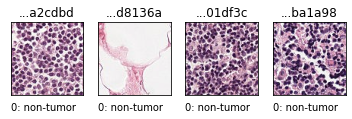

In [9]:
_path_histo_download = "/home/data/02_SSD4TB/suzy/datasets/public/testy"

train_dataset = HistocancerDataset(_path_histo_download, mode = "val", download = True)

In [10]:
len(train_dataset)

22003

In [ ]:
len(t)

In [66]:
len(train_dataset)

57458